# Anderson model of localization

## parameter choices

In [1]:
myseed= 111111
width= 20
nimages= 100
img_sizeX= 100
img_sizeY= img_sizeX

validation_split= 0.1
batch_size= 64
myepochs= num_epochs =10
mylr= 0.01
mywd= 1e-6

dataname='L'+str(width)+'-'+str(nimages)+'-s'+str(img_sizeX)

datapath = '/storage/disqs/'+'ML-Data/Anderson/Images/'+dataname # SC-RTP
#datapath = '/mnt/DataDrive/'+'ML-Data/Anderson/Images/'+dataname # Ubuntu home RAR
    
print(dataname,"\n",datapath)

method='Keras-Resnet50-'+str(myseed)+'-e'+str(num_epochs) #+'-bs'+str(batch_size)
modelname = 'Model_'+method+'_'+dataname+'.pth'
historyname = 'History_'+method+'_'+dataname+'.pkl'
print(method,"\n",modelname,"\n",historyname)

savepath = './'+dataname+'/'
import os
try:
    os.mkdir(savepath)
except FileExistsError:
    pass

modelpath = savepath+modelname
historypath = savepath+historyname
print(savepath,modelpath,historypath)

L20-100-s100 
 /storage/disqs/ML-Data/Anderson/Images/L20-100-s100
Keras-Resnet50-111111-e10 
 Model_Keras-Resnet50-111111-e10_L20-100-s100.pth 
 History_Keras-Resnet50-111111-e10_L20-100-s100.pkl
./L20-100-s100/ ./L20-100-s100/Model_Keras-Resnet50-111111-e10_L20-100-s100.pth ./L20-100-s100/History_Keras-Resnet50-111111-e10_L20-100-s100.pkl


## initializations

In [2]:
#standard notebook settings
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
#standard libraries
import numpy as np
import sys
np.set_printoptions(threshold=sys.maxsize)

import random as rn
import os
import matplotlib.pyplot as plt
#np.random.seed(1337) # for reproducibility
#np.random.seed(2000) 

In [4]:
#machine learning libraries
import tensorflow as tf 
import keras
print("tensorflow: ",tf.__version__, ", keras: ", keras.__version__)

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
print("sklearn: ", sklearn.__version__)

Using TensorFlow backend.


tensorflow:  2.1.0 , keras:  2.3.1
sklearn:  0.21.3


In [5]:
#special subroutines
from keras.models import Sequential
from keras.layers import Dense, Conv2D
from keras.layers import Conv1D, MaxPooling2D
from keras.layers import AveragePooling2D, Flatten
from keras.layers import Dropout
from keras import optimizers
from keras.models import load_model

# from tensorflow.keras.layers import Dense, Conv2D
# from tensorflow.keras.layers import Conv1D, MaxPooling2D
# from tensorflow.keras.layers import AveragePooling2D, Flatten
# from tensorflow.keras.layers import Dropout
# from tensorflow.keras.models import Sequential


# from tensorflow.keras.utils import to_categorical

# import numpy

## starting the main code

In [6]:
np.random.seed(myseed) # necessary for starting Numpy generated random numbers in a well-defined initial state.
rn.seed(myseed+1) # necessary for starting core Python generated random numbers in a well-defined state.

# The below is necessary in Python 3.2.3 onwards to
# have reproducible behavior for certain hash-based operations.
# See these references for further details:
# https://docs.python.org/3.4/using/cmdline.html#envvar-PYTHONHASHSEED
# https://github.com/fchollet/keras/issues/2280#issuecomment-306959926

os.environ['PYTHONHASHSEED'] = '0'

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of
# non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

from tensorflow.keras import backend as K

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.compat.v2.random.set_seed(myseed+3)
#tf.set_random_seed(1234)

#sess = tf.compat.v2.Session(graph=tf.get_default_graph(), config=session_conf)
#K.set_session(sess)

## reading the images

In [7]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,validation_split=validation_split)
test_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
training_set = train_datagen.flow_from_directory(datapath,
                                                 subset='training',
                                                 target_size = (img_sizeX,img_sizeY),
                                                 batch_size = batch_size, 
                                                 class_mode='categorical',
                                                shuffle=True,seed=myseed)

validation_set= train_datagen.flow_from_directory(datapath, 
                                              subset='validation', 
                                              target_size = (img_sizeX,img_sizeY),
                                              batch_size = batch_size,
                                              class_mode='categorical',
                                                 shuffle=False,seed=myseed)

# test_set = test_datagen.flow_from_directory('data-keras-L20-100/test_set',
#                                             target_size = (171, 171),
#                                             batch_size = batch_size,
#                                             class_mode='categorical',
#                                            shuffle=False)

Found 1530 images belonging to 17 classes.
Found 170 images belonging to 17 classes.


In [9]:
# X_train, X_labels = next(training_set)
# Y_train, Y_labels = next(validation_set)
# len(X_train),len(X_labels),len(Y_train),len(Y_labels)

In [10]:
num_of_train_samples = training_set.samples
num_of_test_samples = validation_set.samples
num_classes = len(validation_set.class_indices)

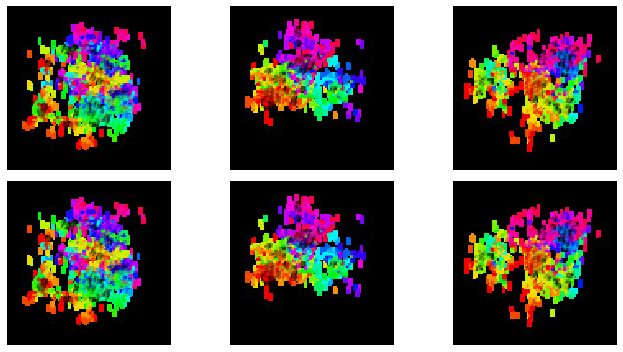

In [11]:
plt.figure(figsize=(10,5))
for i in range(6):
    plt.subplot(2,3,i+1)
    for x,y in validation_set:
        plt.imshow(x[0],cmap='hsv')
        #plt.title('y={}'.format(y[0]))
        plt.axis('off')
        break
plt.tight_layout()
plt.show()

## building the CNN

In [12]:
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image

resnet = ResNet50(include_top=False,weights='imagenet',input_shape=(img_sizeX, img_sizeY, 3))

def create_CNN():
    # instantiate model
    model= Sequential([
        resnet,Flatten(),
        Dense(num_classes, activation='sigmoid'),
    ])
    
    return model

print('CNN architecture (Resnet50) created successfully!')

/warwick/desktop/2018/software/TensorFlow/2.1.0-fosscuda-2019b-Python-3.7.4/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


CNN architecture (Resnet50) created successfully!


In [13]:
# Choose the Optimizer and the Cost Function

opt = optimizers.SGD(lr=mylr, decay=mywd)
#opt = keras.optimizers.Adam(lr=mylr, decay=mywd)

def compile_model(optimizer=opt):
    # create the mode
    model=create_CNN()
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

print('Model compiled successfully and ready to be trained.')

Model compiled successfully and ready to be trained.


In [14]:
# opt = optimizers.SGD(lr=mylr, decay=mywd)
# model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

# create the deep neural net
model = compile_model()
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 4, 4, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 17)                557073    
Total params: 24,144,785
Trainable params: 24,091,665
Non-trainable params: 53,120
_________________________________________________________________
None


## learning the images

In [15]:
# train DNN and store training info in history
history = model.fit_generator(training_set,
                         steps_per_epoch = training_set.samples // batch_size,
                         epochs = myepochs,
                         validation_data = validation_set,
                         validation_steps = validation_set.samples // batch_size)

Epoch 1/10
23/23 [==============================] - 32s 1s/step - loss: 2.8757 - accuracy: 0.0682 - val_loss: 3.0671 - val_accuracy: 0.0000e+00
Epoch 2/10
23/23 [==============================] - 5s 211ms/step - loss: 2.6268 - accuracy: 0.1917 - val_loss: 4.1477 - val_accuracy: 0.0943
Epoch 3/10
23/23 [==============================] - 5s 200ms/step - loss: 2.4206 - accuracy: 0.2872 - val_loss: 3.1386 - val_accuracy: 0.1038
Epoch 4/10
23/23 [==============================] - 5s 199ms/step - loss: 1.7988 - accuracy: 0.4598 - val_loss: 2.6858 - val_accuracy: 0.0781
Epoch 5/10
23/23 [==============================] - 5s 205ms/step - loss: 0.8853 - accuracy: 0.7483 - val_loss: 5.5315 - val_accuracy: 0.0943
Epoch 6/10
23/23 [==============================] - 4s 195ms/step - loss: 0.1822 - accuracy: 0.9543 - val_loss: 4.1543 - val_accuracy: 0.0943
Epoch 7/10
23/23 [==============================] - 5s 201ms/step - loss: 0.0225 - accuracy: 0.9980 - val_loss: 3.6398 - val_accuracy: 0.0625
Epoc

In [16]:
# tf.keras.models.save_model(history,'Anderson_Ohtsuki_model_L20_500_keras_SGD_0_01_good_input_size.h5') 
model.save(modelpath) 

import pickle 
f=open(historypath,"wb")
pickle.dump(history,f)
f.close()

## testing the quality of the learned model

In [17]:
#history = load_model(modelpath)

### training history

3/3 [==============================] - 0s 64ms/step

Test loss: 4.476531028747559
Test accuracy: 0.05882352963089943


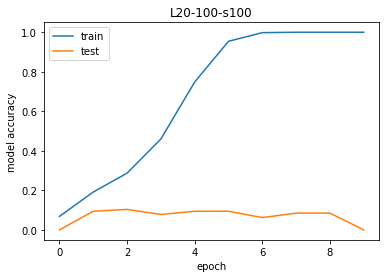

In [18]:
# evaluate model
score=model.evaluate(validation_set,verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# look into training history

# summarize history for accuracy
fig=plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.title(dataname)
plt.show()
fig.savefig(savepath+'/'+method+'_'+dataname+'_accuracy'+'.png')

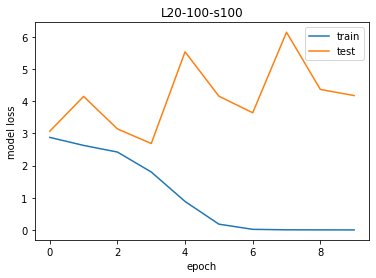

In [19]:
# summarize history for loss
fig=plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.title(dataname)
plt.show()
fig.savefig(savepath+'/'+method+'_'+dataname+'_loss'+'.png')

### confusion matrix

In [20]:
validation_set.reset()
label=validation_set.class_indices.keys()

#Confusion Matrix 
Y_pred = model.predict_generator(validation_set, num_of_test_samples // batch_size+1, verbose=1)
y_pred = np.argmax(Y_pred, axis=1)

#basic confusion matrix
confusion_matrix(validation_set.classes, y_pred)

3/3 [==============================] - 3s 1s/step


array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  0,  0,  8,
         0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 10,
         0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 10,
         0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  0,  0,  8,
         0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 10,
         0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 10,
         0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  9,
         0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 10,
         0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 10,
         0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 10,
         0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 10,
         0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  

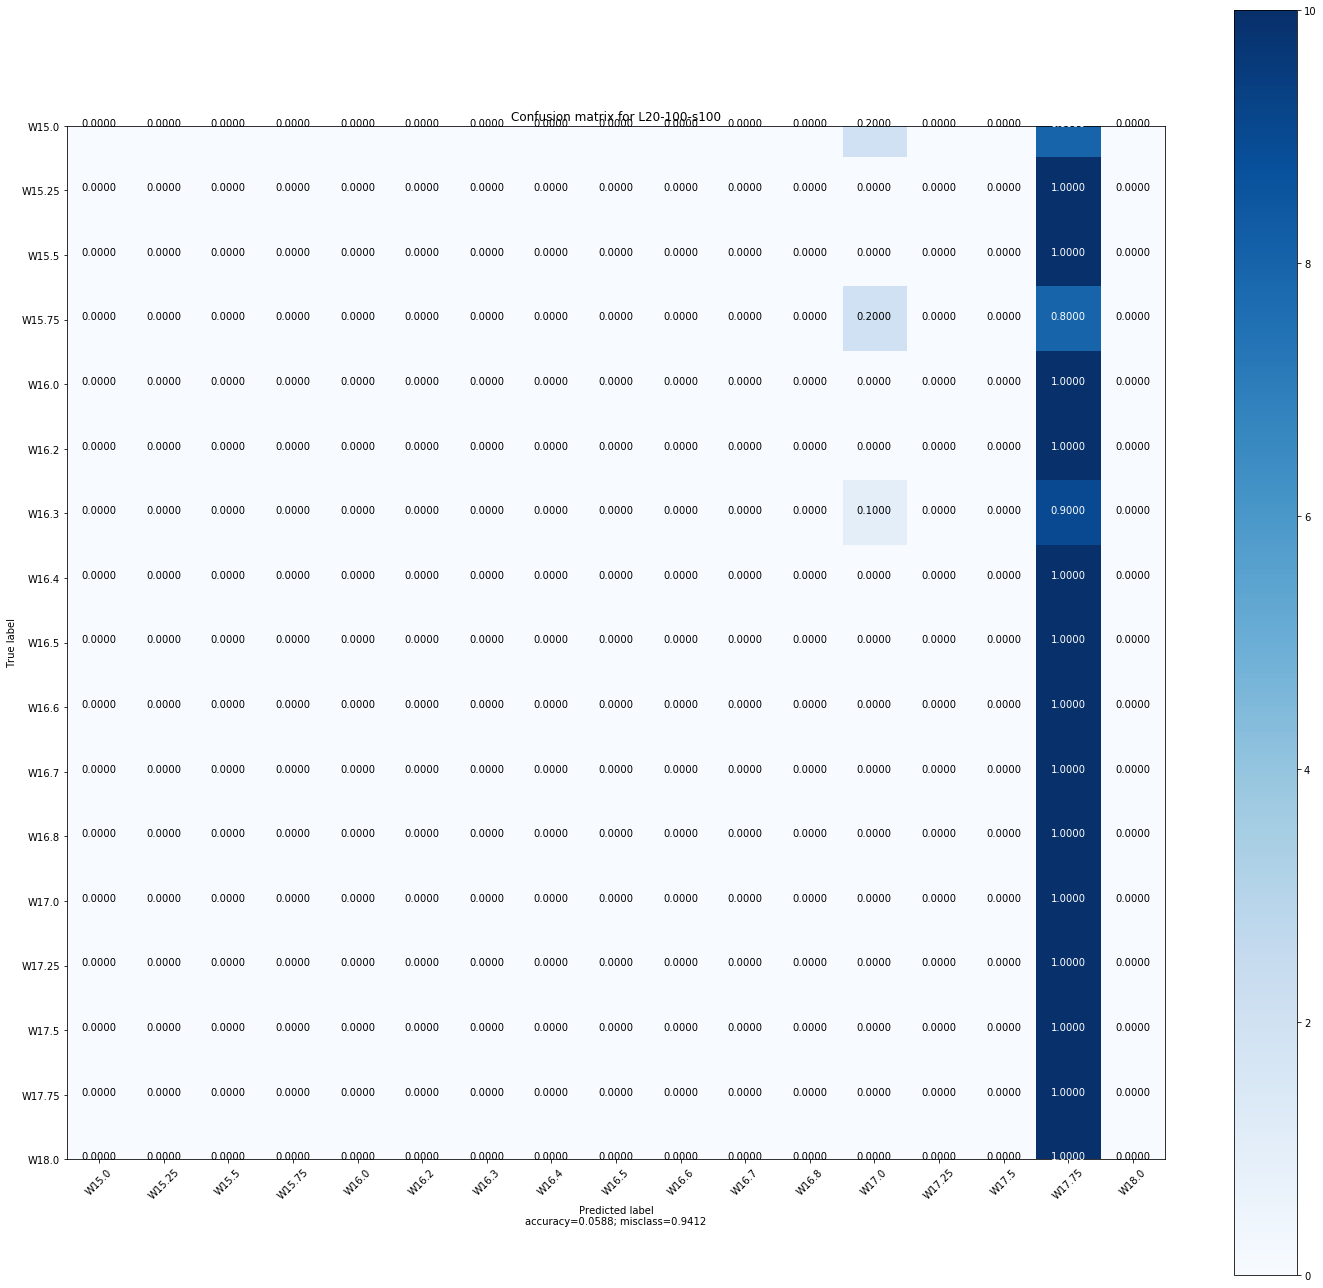

None


In [21]:
os.chdir('../PyCode/')
from plot_confusion_matrix import *

print(plot_confusion_matrix(confusion_matrix(validation_set.classes, y_pred),
                          label,
                          title='Confusion matrix for '+dataname,
                          cmap=None,
                          normalize=True))
os.chdir('../src/')